## Introducción al aprendizaje supervisado

In [1]:
import pandas as pd

In [2]:
import numpy as np

In [3]:
import seaborn as sns

In [4]:
import datetime as dt

In [5]:
import matplotlib.pyplot as plt

In [6]:
from time import time

In [7]:
from sklearn.preprocessing import Normalizer, StandardScaler, LabelEncoder

In [8]:
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

In [9]:
from sklearn.tree import DecisionTreeRegressor

In [10]:
from sklearn.metrics import accuracy_score

### Actividades:

#### Dataset rain_teodelina

1) agregar features que aporten valor al dataset  

2) Analizar features data / target 

3) dividir dataset (training, validation, test)    

4) analizar y elegir el modelo mas apropiado, entrenarlo y analizar resultados  

5) combinar clasificadores y analizar resultados  

6) evaluar predicciones de los diferentes modelos  

In [110]:
rain_t = pd.read_csv("rain_teodelina.csv", parse_dates = ["date"], index_col=[0])
rain_t.head()

,rain
date,
1978-01-01,0
1978-01-02,0
1978-01-03,0
1978-01-04,0
1978-01-05,0


In [111]:
rain_t.describe(include='all')

,rain
count,15034.000000
mean,3.331914
std,11.451975
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,220.000000


In [112]:
missing_values_count_t = rain_t.isnull().sum()
missing_values_count_t[missing_values_count_t > 0]

Series([], dtype: int64)

In [113]:
rain_t['mes'] = rain_t.index.month
rain_t['año'] = rain_t.index.year
#lluvias['mesHid'] = (lluvias.index.month+5)%12+1
rain_t['añoHid'] = (rain_t.index + dt.timedelta(days=181))
rain_t['mesHid'] = rain_t.añoHid.dt.month

In [114]:
rain_t.describe(include='all')

,rain,mes,año,añoHid,mesHid
count,15034.000000,15034.000000,15034.000000,15034,15034.000000
unique,NaN,NaN,NaN,15034,NaN
top,NaN,NaN,NaN,1989-12-27 00:00:00,NaN
freq,NaN,NaN,NaN,1,NaN
first,NaN,NaN,NaN,1978-07-01 00:00:00,NaN
last,NaN,NaN,NaN,2019-08-28 00:00:00,NaN
mean,3.331914,6.503193,1998.082413,NaN,6.526739
std,11.451975,3.456608,11.881857,NaN,3.442680
min,0.000000,1.000000,1978.000000,NaN,1.000000
25%,0.000000,3.250000,1988.000000,NaN,4.000000


In [115]:
AcumMensual = pd.pivot_table(rain_t, values='rain', index=['año'],columns=['mes'], aggfunc=np.sum, margins=True)

In [116]:
sumas_short = AcumMensual.drop(['All'], axis=1)
sumas_short = sumas_short.drop([2019,'All'], axis=0)
sumas_short

mes,1,2,3,4,5,6,7,8,9,10,11,12
año,,,,,,,,,,,,
1978,217.0,140.0,204.0,77.0,29.0,16.0,68.0,22.0,303.0,132.0,235.0,50.0
1979,110.0,173.0,166.0,89.0,14.0,47.0,17.0,9.0,29.0,69.0,190.0,120.0
1980,21.0,113.0,214.0,174.0,30.0,54.0,11.0,5.0,17.0,173.0,112.0,107.0
1981,297.0,108.0,179.0,92.0,82.0,35.0,16.0,1.0,47.0,103.0,147.0,81.0
1982,228.0,199.0,103.0,111.0,3.0,26.0,13.0,0.0,107.0,31.0,133.0,52.0
1983,113.0,148.0,52.0,86.0,50.0,6.0,5.0,32.0,11.0,202.0,127.0,40.0
1984,203.0,365.0,113.0,39.0,30.0,12.0,12.0,24.0,74.0,160.0,105.0,81.0
1985,83.0,149.0,61.0,82.0,62.0,0.0,85.0,36.0,71.0,158.0,147.0,75.0
1986,331.0,50.0,37.0,139.0,22.0,40.0,6.0,31.0,79.0,150.0,131.0,16.0


In [117]:
precipitation = rain_t.rain

consecutive_dry = [1 if data == 0 else 0 for data in precipitation]
for i in range(1, len(consecutive_dry)):
    if consecutive_dry[i] == 1:
        consecutive_dry[i] += consecutive_dry[i - 1]
        
consecutive_wet = [1 if data > 0 else 0 for data in precipitation]
for i in range(1, len(consecutive_wet)):
    if consecutive_wet[i] == 1:
        consecutive_wet[i] += consecutive_wet[i - 1]

rain_t['cons_dry'] = consecutive_dry
rain_t['cons_wet'] = consecutive_wet

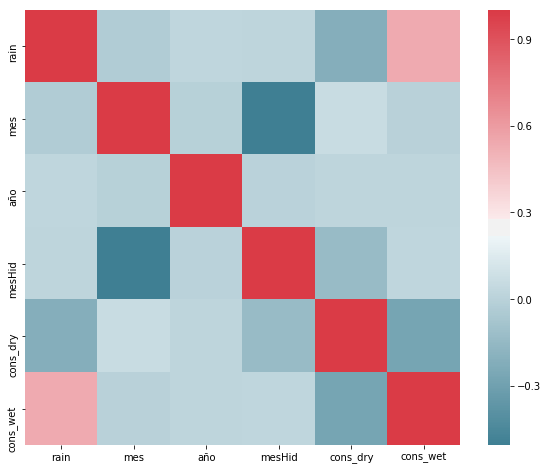

In [118]:
corr_t = rain_t.corr()
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_t, mask=np.zeros_like(corr_t, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True), square=True, ax=ax)

In [119]:
y_orig = rain_t['rain']  #columnas objetivo
X_orig = rain_t.drop('rain', axis=1)  #columnas independientes

In [120]:
X2 = X_orig.drop('añoHid', axis=1)
X3 = np.around(X2, decimals = 0, out = None)
X3 = X3.astype(int)
y3 = np.around(y_orig, decimals = 0, out = None)
y3 = y3.astype(int)

In [121]:
# split training dataset into test and train 
# (we won't be using testing sets here, because of the cross-validation; but it couldn be useful)
X_train, X_test, y_train, y_test = train_test_split(X3, y3, test_size=0.3, random_state=42) ##test_size conviene 0.2???

In [122]:
results = pd.DataFrame(columns=('clf', 'best_res'))

## Logistic Regression
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(multi_class = 'auto', random_state = 42)
lr_param = {'penalty':('l2', 'l1'), 'C':[1.0], 'warm_start':[True, False]}

lr_clf = GridSearchCV(lr, lr_param, cv=5, iid=False)
start = time()
lr_clf.fit(X_train, y_train)
best_lr_clf = lr_clf.best_estimator_
print('Best Log Reg: ', lr_clf.best_score_)
print(best_lr_clf)
results = results.append({'clf': best_lr_clf, 'best_res': lr_clf.best_score_}, ignore_index=True)

print('The best classifier so far is: ')
print(results.loc[results['best_res'].idxmax()]['clf'])

print("Log Reg tomó %.2f segundos para %d configuraciones de parámetros candidatos."
      % (time() - start, len(lr_clf.cv_results_['params'])))
for i in range(len(lr_clf.cv_results_['params'])+1):
    candidatos = np.flatnonzero(lr_clf.cv_results_['rank_test_score'] == i)
    for candidato in candidatos:
        print("El modelo con el ranking: {0}".format(i))
        print("Scores de validación Medios: {0:.3f} (std: {1:.3f})".format(
                  lr_clf.cv_results_['mean_test_score'][candidato],
                  lr_clf.cv_results_['std_test_score'][candidato]))
        print("Parametros: {0}".format(lr_clf.cv_results_['params'][candidato]))
        print("")


C:\Users\javi\.conda\envs\diplodatos\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\javi\.conda\envs\diplodatos\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\javi\.conda\envs\diplodatos\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\javi\.conda\envs\diplodatos\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\javi\.conda\envs\diplodatos\lib\site-packages\s

Best Log Reg:  0.8500177910685153
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='auto',
          n_jobs=None, penalty='l2', random_state=42, solver='warn',
          tol=0.0001, verbose=0, warm_start=True)
The best classifier so far is: 
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='auto',
          n_jobs=None, penalty='l2', random_state=42, solver='warn',
          tol=0.0001, verbose=0, warm_start=True)
Log Reg tomó 47.40 segundos para 4 configuraciones de parámetros candidatos.
El modelo con el ranking: 1
Scores de validación Medios: 0.850 (std: 0.012)
Parametros: {'C': 1.0, 'penalty': 'l2', 'warm_start': True}

El modelo con el ranking: 1
Scores de validación Medios: 0.850 (std: 0.012)
Parametros: {'C': 1.0, 'penalty': 'l2', 'warm_start': False}

El modelo con el ranking: 3
Scores de validación Medios: 0.8

In [124]:
from sklearn.linear_model import LogisticRegression

results = pd.DataFrame(columns=('clf', 'best_res'))

lr_clf2 = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='auto',
          n_jobs=None, penalty='l2', random_state=42, solver='warn',
          tol=0.0001, verbose=0, warm_start=True)

lr_clf2.fit(X_train, y_train)
results = results.append({'clf': lr_clf2}, ignore_index=True)

print('Logistic Regression:')
print('Score para entrenamiento: %.2f' % 
      accuracy_score(y_train, lr_clf2.predict(X_train)))
print('Score para evaluación: %.2f' %
      accuracy_score(y_test, lr_clf2.predict(X_test)))

C:\Users\javi\.conda\envs\diplodatos\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Logistic Regression:
Score para entrenamiento: 0.85
Score para evaluación: 0.84


In [125]:
results = pd.DataFrame(columns=('clf', 'best_res'))

## Stochastic Gradient
from sklearn.linear_model import SGDClassifier


#parameters_SGDC = {'loss':('hinge', 'log'), 'max_iter': [10000], 'tol': [0.001]}
parameters_SGDC = {'loss':('hinge', 'log'), 'learning_rate':('adaptive', 'optimal', 'invscaling'),
              'penalty':('l2', 'l1', 'elasticnet'), 'alpha':[0.0001], 'max_iter': [10000], 
              'eta0': [0.1], 'tol': [0.001]}
SGDC = SGDClassifier(random_state=42)
SGDC_clf = GridSearchCV(SGDC, parameters_SGDC, cv=5, iid = False, return_train_score = True)
start = time()
SGDC_clf.fit(X_train, y_train)
best_SGDC_clf = SGDC_clf.best_estimator_

print('Best SGDC score: ', SGDC_clf.best_score_)
print(best_SGDC_clf)
results = results.append({'clf': best_SGDC_clf, 'best_res': SGDC_clf.best_score_}, ignore_index=True)

print('The best classifier so far is: ')
print(results.loc[results['best_res'].idxmax()]['clf'])
print("")

print("GridSearchCV tomó %.2f segundos para %d configuraciones de parámetros candidatos."
      % (time() - start, len(SGDC_clf.cv_results_['params'])))
for i in range(len(SGDC_clf.cv_results_['params'])+1):
    candidatos = np.flatnonzero(SGDC_clf.cv_results_['rank_test_score'] == i)
    for candidato in candidatos:
        print("El modelo con el ranking: {0}".format(i))
        print("Scores de validación Medios: {0:.3f} (std: {1:.3f})".format(
                  SGDC_clf.cv_results_['mean_test_score'][candidato],
                  SGDC_clf.cv_results_['std_test_score'][candidato]))
        print("Parametros: {0}".format(SGDC_clf.cv_results_['params'][candidato]))
        print("")

C:\Users\javi\.conda\envs\diplodatos\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Best SGDC score:  0.844255405679211
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.1, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge',
       max_iter=10000, n_iter=None, n_iter_no_change=5, n_jobs=None,
       penalty='l1', power_t=0.5, random_state=42, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False)
The best classifier so far is: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.1, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge',
       max_iter=10000, n_iter=None, n_iter_no_change=5, n_jobs=None,
       penalty='l1', power_t=0.5, random_state=42, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False)

GridSearchCV tomó 1875.04 segundos para 18 configuraciones de parámetros candidatos.
El modelo con el ranking: 1
Scores de valida

C:\Users\javi\.conda\envs\diplodatos\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


In [126]:
from sklearn.linear_model import SGDClassifier

results = pd.DataFrame(columns=('clf', 'best_res'))

SGDC_clf2 = SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.1, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge',
       max_iter=10000, n_iter=None, n_iter_no_change=5, n_jobs=None,
       penalty='l1', power_t=0.5, random_state=42, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False)

SGDC_clf2.fit(X_train, y_train)
results = results.append({'clf': SGDC_clf2}, ignore_index=True)

print('Stochastic Descendent Gradient:')
print('Score para entrenamiento: %.2f' % 
      accuracy_score(y_train, SGDC_clf2.predict(X_train)))
print('Score para evaluación: %.2f' %
      accuracy_score(y_test, SGDC_clf2.predict(X_test)))

Stochastic Descendent Gradient:
Score para entrenamiento: 0.84
Score para evaluación: 0.83


C:\Users\javi\.conda\envs\diplodatos\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


#### Dataset: rain_junin

1) Aplicar tecnicas de selección y extraccion de features  

2) Analizar features data / target 

3) dividir dataset (training, validation, test)  

4) analizar y elegir el modelo mas apropiado, entrenarlo y analizar resultados

5) combinar clasificadores y analizar resultados  

6) evaluar predicciones de los diferentes modelos  

In [128]:
rain_junin = pd.read_csv("rain_junin_usar.csv", parse_dates = ["Fecha"], index_col=[0])
rain_junin.head()

,Hr.Med(%),Prec(mm),Presion(mb).Est,Presion(mb).Mar,Temperatura(°C).Max,Temperatura(°C).Med,Temperatura(°C).Min,Viento(km/h).Max,Viento(km/h).Med,Vis(km)
Fecha,,,,,,,,,,
2016-01-01,71.8,7.9,1000.1,1009.5,31.4,24.0,18.4,27.8,16.7,12.4
2016-01-02,67.8,0.0,1002.0,1011.4,32.1,25.6,20.3,25.9,19.3,12.8
2016-01-03,79.1,0.0,1001.0,1010.4,31.6,23.7,20.0,37.0,21.7,12.6
2016-01-04,91.5,0.0,999.6,1009.0,26.9,22.2,20.8,18.3,10.7,10.4
2016-01-05,79.6,9.9,1002.6,1012.0,28.4,23.6,19.8,24.1,14.4,11.3


In [129]:
rain_junin.describe(include='all')

,Hr.Med(%),Prec(mm),Presion(mb).Est,Presion(mb).Mar,Temperatura(°C).Max,Temperatura(°C).Med,Temperatura(°C).Min,Viento(km/h).Max,Viento(km/h).Med,Vis(km)
count,1066.000000,1050.000000,1066.000000,1066.000000,1066.000000,1066.000000,1066.000000,1065.000000,1066.000000,1066.000000
mean,69.875141,3.424095,1005.528424,1015.193621,23.837523,16.232176,10.133865,24.056901,14.788180,12.209287
std,12.923685,11.106181,6.087682,6.271942,6.503449,5.732337,5.833879,8.268677,5.480464,2.315869
min,29.400000,0.000000,991.100000,1000.400000,8.600000,2.800000,-6.200000,7.600000,2.800000,2.600000
25%,60.900000,0.000000,1001.400000,1010.900000,18.825000,11.600000,6.000000,18.300000,10.900000,11.100000
50%,70.500000,0.000000,1005.100000,1014.850000,24.200000,16.450000,10.200000,24.100000,14.100000,12.600000
75%,79.500000,0.000000,1009.600000,1019.400000,29.200000,20.800000,14.875000,29.400000,18.500000,13.900000
max,97.800000,151.900000,1024.800000,1034.900000,36.800000,29.000000,22.500000,53.500000,38.700000,17.200000


In [130]:
#rain_junin = rain_junin.drop(['Prec(mm)'], axis=1)
rain_junin.head()

,Hr.Med(%),Prec(mm),Presion(mb).Est,Presion(mb).Mar,Temperatura(°C).Max,Temperatura(°C).Med,Temperatura(°C).Min,Viento(km/h).Max,Viento(km/h).Med,Vis(km)
Fecha,,,,,,,,,,
2016-01-01,71.8,7.9,1000.1,1009.5,31.4,24.0,18.4,27.8,16.7,12.4
2016-01-02,67.8,0.0,1002.0,1011.4,32.1,25.6,20.3,25.9,19.3,12.8
2016-01-03,79.1,0.0,1001.0,1010.4,31.6,23.7,20.0,37.0,21.7,12.6
2016-01-04,91.5,0.0,999.6,1009.0,26.9,22.2,20.8,18.3,10.7,10.4
2016-01-05,79.6,9.9,1002.6,1012.0,28.4,23.6,19.8,24.1,14.4,11.3


In [131]:
rain_junin.describe()

,Hr.Med(%),Prec(mm),Presion(mb).Est,Presion(mb).Mar,Temperatura(°C).Max,Temperatura(°C).Med,Temperatura(°C).Min,Viento(km/h).Max,Viento(km/h).Med,Vis(km)
count,1066.000000,1050.000000,1066.000000,1066.000000,1066.000000,1066.000000,1066.000000,1065.000000,1066.000000,1066.000000
mean,69.875141,3.424095,1005.528424,1015.193621,23.837523,16.232176,10.133865,24.056901,14.788180,12.209287
std,12.923685,11.106181,6.087682,6.271942,6.503449,5.732337,5.833879,8.268677,5.480464,2.315869
min,29.400000,0.000000,991.100000,1000.400000,8.600000,2.800000,-6.200000,7.600000,2.800000,2.600000
25%,60.900000,0.000000,1001.400000,1010.900000,18.825000,11.600000,6.000000,18.300000,10.900000,11.100000
50%,70.500000,0.000000,1005.100000,1014.850000,24.200000,16.450000,10.200000,24.100000,14.100000,12.600000
75%,79.500000,0.000000,1009.600000,1019.400000,29.200000,20.800000,14.875000,29.400000,18.500000,13.900000
max,97.800000,151.900000,1024.800000,1034.900000,36.800000,29.000000,22.500000,53.500000,38.700000,17.200000


En primer lugar, previo al análisis de Features, se cuantifican el número de datos faltantes para su posterior procesamiento:

In [132]:
missing_values_count = rain_junin.isnull().sum()
missing_values_count[missing_values_count > 0]

Hr.Med(%)              30
Prec(mm)               46
Presion(mb).Est        30
Presion(mb).Mar        30
Temperatura(°C).Max    30
Temperatura(°C).Med    30
Temperatura(°C).Min    30
Viento(km/h).Max       31
Viento(km/h).Med       30
Vis(km)                30
dtype: int64

Todos los datos son tipo "int64" y el número de datos faltantes es del orden de 30, salvo para las precipitaciones que resultan del orden de 46. Para procesarlos, a continuación realizaremos una interpolación:

In [133]:
rain_junin_clean = rain_junin.interpolate()

missing_values_count = rain_junin_clean.isnull().sum()
missing_values_count[missing_values_count > 0]

Series([], dtype: int64)

No existen más datos faltantes. A continuación, realizaremos el análisis de selección de Features.

Una técnica de análisis de los features más sensibles es aplicar una matriz de correlaciones y plotearlo con un mapa de Heatmap para ayudar en la interpretación de los resultados:

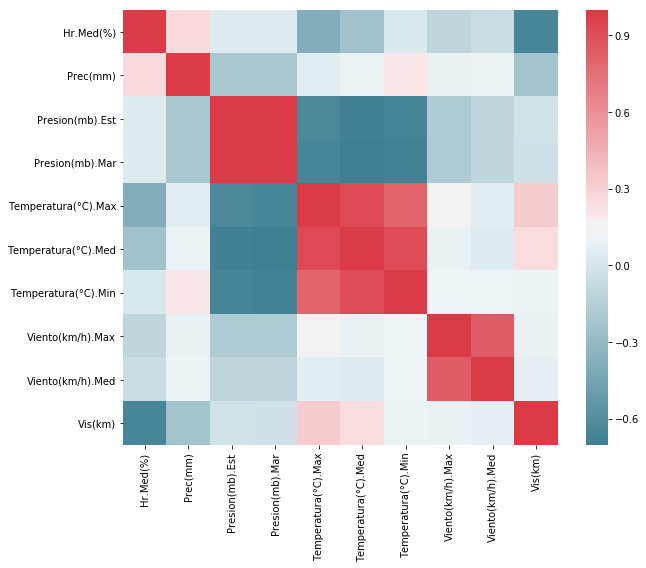

In [134]:
corr = rain_junin_clean.corr()
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True), square=True, ax=ax)

In [135]:
rain_junin_clean.columns

Index(['Hr.Med(%)', 'Prec(mm)', 'Presion(mb).Est', 'Presion(mb).Mar',
       'Temperatura(°C).Max', 'Temperatura(°C).Med', 'Temperatura(°C).Min',
       'Viento(km/h).Max', 'Viento(km/h).Med', 'Vis(km)'],
      dtype='object')

A continuación, se seleccionarán las features más representativas a partir de "SelectKBest"

In [136]:
y_orig = rain_junin_clean['Prec(mm)']  #columnas objetivo
X_orig = rain_junin_clean.drop('Prec(mm)', axis=1)  #columnas independientes
#X1 = X_orig.drop('Fecha', axis=1)
#X1.describe()

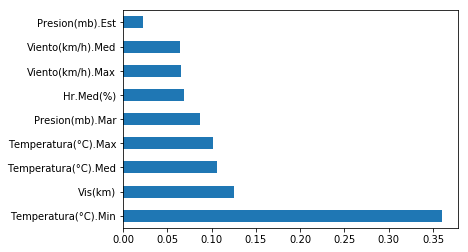

,Temperatura(°C).Min,Vis(km),Temperatura(°C).Med,Temperatura(°C).Max,Presion(mb).Mar,Hr.Med(%)
Fecha,,,,,,
2016-01-01,18.4,12.4,24.0,31.4,1009.5,71.8
2016-01-02,20.3,12.8,25.6,32.1,1011.4,67.8
2016-01-03,20.0,12.6,23.7,31.6,1010.4,79.1
2016-01-04,20.8,10.4,22.2,26.9,1009.0,91.5
2016-01-05,19.8,11.3,23.6,28.4,1012.0,79.6
2016-01-06,13.6,13.9,21.8,29.1,1016.7,53.2
2016-01-07,14.0,13.9,21.4,28.0,1015.8,60.1
2016-01-08,17.0,13.1,22.5,29.0,1011.9,66.0
2016-01-09,17.8,13.1,21.1,30.1,1014.4,79.6


In [143]:
model = DecisionTreeRegressor()
model.fit(X_orig,y_orig)

#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X_orig.columns)
feat_importances.nlargest(9).plot(kind='barh')
f1 = feat_importances.nlargest(6)
plt.show()
X2 = X_orig[f1.index]
X2

A continuación se normalizan los valores anteriores.

In [144]:
scaler = Normalizer().fit(X2)
#scaler = StandardScaler().fit(X2)
std_X2 = scaler.transform(X2)
std_X2

# from sklearn.preprocessing import StandardScaler
# sc = StandardScaler()
# sc_X_train = sc.fit_transform(X_train)
# sc_X_test = sc.transform(X_test)

array([[0.01816271, 0.01224009, 0.02369049, 0.03099506, 0.99648142,
        0.07087406],
       [0.02000424, 0.01261351, 0.02522702, 0.03163232, 0.99666436,
        0.06681219],
       [0.01971344, 0.01241947, 0.02336042, 0.03114723, 0.99592293,
        0.07796665],
       ...,
       [0.01582805, 0.01266244, 0.02097216, 0.02750123, 0.99696908,
        0.06667565],
       [0.01582805, 0.01266244, 0.02097216, 0.02750123, 0.99696908,
        0.06667565],
       [0.01582805, 0.01266244, 0.02097216, 0.02750123, 0.99696908,
        0.06667565]])

Como arrojaban errores de que no podía ajustarse el algoritmo de regresión lineal o logística a los datos anteriores por ser del tipo flotante, se los redondeó de la siguiente manera:

In [145]:
X3 = np.around(X2, decimals = 0, out = None)
X3 = X3.astype(int)
y3 = np.around(y_orig, decimals = 0, out = None)
y3 = y3.astype(int)

Los set de train y test se repartieron en 70% y 30% respectivamente:

In [146]:
# split training dataset into test and train 
# (we won't be using testing sets here, because of the cross-validation; but it couldn be useful)
X_train, X_test, y_train, y_test = train_test_split(X3, y3, test_size=0.3, random_state=42) ##test_size conviene 0.2???

La regresión Logística dió muy buenos resultados. Cabe resaltar que el accuracy es una métrica de Clasificación y en este caso estamos lidiando con Regresión.

In [48]:
results = pd.DataFrame(columns=('clf', 'best_res'))

## Logistic Regression
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(multi_class = 'auto', random_state = 42)
lr_param = {'penalty':('l2', 'l1'), 'C':[1.0], 'warm_start':[True, False]}

lr_clf = GridSearchCV(lr, lr_param, cv=5, iid=False)
start = time()
lr_clf.fit(X_train, y_train)
best_lr_clf = lr_clf.best_estimator_
print('Best Log Reg: ', lr_clf.best_score_)
print(best_lr_clf)
results = results.append({'clf': best_lr_clf, 'best_res': lr_clf.best_score_}, ignore_index=True)

print('The best classifier so far is: ')
print(results.loc[results['best_res'].idxmax()]['clf'])

print("Log Reg tomó %.2f segundos para %d configuraciones de parámetros candidatos."
      % (time() - start, len(lr_clf.cv_results_['params'])))
for i in range(len(lr_clf.cv_results_['params'])+1):
    candidatos = np.flatnonzero(lr_clf.cv_results_['rank_test_score'] == i)
    for candidato in candidatos:
        print("El modelo con el ranking: {0}".format(i))
        print("Scores de validación Medios: {0:.3f} (std: {1:.3f})".format(
                  lr_clf.cv_results_['mean_test_score'][candidato],
                  lr_clf.cv_results_['std_test_score'][candidato]))
        print("Parametros: {0}".format(lr_clf.cv_results_['params'][candidato]))
        print("")


C:\Users\javi\.conda\envs\diplodatos\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\javi\.conda\envs\diplodatos\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\javi\.conda\envs\diplodatos\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\javi\.conda\envs\diplodatos\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\javi\.conda\envs\diplodatos\lib\site-packages\s

Best Log Reg:  0.7905001047987451
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='auto',
          n_jobs=None, penalty='l1', random_state=42, solver='warn',
          tol=0.0001, verbose=0, warm_start=True)
The best classifier so far is: 
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='auto',
          n_jobs=None, penalty='l1', random_state=42, solver='warn',
          tol=0.0001, verbose=0, warm_start=True)
Log Reg tomó 4.23 segundos para 4 configuraciones de parámetros candidatos.
El modelo con el ranking: 1
Scores de validación Medios: 0.791 (std: 0.072)
Parametros: {'C': 1.0, 'penalty': 'l1', 'warm_start': True}

El modelo con el ranking: 1
Scores de validación Medios: 0.791 (std: 0.072)
Parametros: {'C': 1.0, 'penalty': 'l1', 'warm_start': False}

El modelo con el ranking: 3
Scores de validación Medios: 0.78

C:\Users\javi\.conda\envs\diplodatos\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [49]:
from sklearn.linear_model import LogisticRegression

results = pd.DataFrame(columns=('clf', 'best_res'))

lr_clf2 = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='auto',
          n_jobs=None, penalty='l2', random_state=42, solver='warn',
          tol=0.0001, verbose=0, warm_start=True)

lr_clf2.fit(X_train, y_train)
results = results.append({'clf': lr_clf2}, ignore_index=True)

print('Logistic Regression:')
print('Score para entrenamiento: %.2f' % 
      accuracy_score(y_train, lr_clf2.predict(X_train)))
print('Score para evaluación: %.2f' %
      accuracy_score(y_test, lr_clf2.predict(X_test)))

Logistic Regression:
Score para entrenamiento: 0.79
Score para evaluación: 0.74


C:\Users\javi\.conda\envs\diplodatos\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [148]:
results = pd.DataFrame(columns=('clf', 'best_res'))

## Stochastic Gradient
from sklearn.linear_model import SGDClassifier


#parameters_SGDC = {'loss':('hinge', 'log'), 'max_iter': [10000], 'tol': [0.001]}
parameters_SGDC = {'loss':('hinge', 'log'), 'learning_rate':('adaptive', 'optimal', 'invscaling'),
              'penalty':('l2', 'l1', 'elasticnet'), 'alpha':[0.0001], 'max_iter': [10000], 
              'eta0': [0.1], 'tol': [0.001]}
SGDC = SGDClassifier(random_state=42)
SGDC_clf = GridSearchCV(SGDC, parameters_SGDC, cv=5, iid = False, return_train_score = True)
start = time()
SGDC_clf.fit(X_train, y_train)
best_SGDC_clf = SGDC_clf.best_estimator_

print('Best SGDC score: ', SGDC_clf.best_score_)
print(best_SGDC_clf)
results = results.append({'clf': best_SGDC_clf, 'best_res': SGDC_clf.best_score_}, ignore_index=True)

print('The best classifier so far is: ')
print(results.loc[results['best_res'].idxmax()]['clf'])
print("")

print("GridSearchCV tomó %.2f segundos para %d configuraciones de parámetros candidatos."
      % (time() - start, len(SGDC_clf.cv_results_['params'])))
for i in range(len(SGDC_clf.cv_results_['params'])+1):
    candidatos = np.flatnonzero(SGDC_clf.cv_results_['rank_test_score'] == i)
    for candidato in candidatos:
        print("El modelo con el ranking: {0}".format(i))
        print("Scores de validación Medios: {0:.3f} (std: {1:.3f})".format(
                  SGDC_clf.cv_results_['mean_test_score'][candidato],
                  SGDC_clf.cv_results_['std_test_score'][candidato]))
        print("Parametros: {0}".format(SGDC_clf.cv_results_['params'][candidato]))
        print("")

C:\Users\javi\.conda\envs\diplodatos\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Best SGDC score:  0.7339747803413788
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.1, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge',
       max_iter=10000, n_iter=None, n_iter_no_change=5, n_jobs=None,
       penalty='elasticnet', power_t=0.5, random_state=42, shuffle=True,
       tol=0.001, validation_fraction=0.1, verbose=0, warm_start=False)
The best classifier so far is: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.1, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge',
       max_iter=10000, n_iter=None, n_iter_no_change=5, n_jobs=None,
       penalty='elasticnet', power_t=0.5, random_state=42, shuffle=True,
       tol=0.001, validation_fraction=0.1, verbose=0, warm_start=False)

GridSearchCV tomó 26.98 segundos para 18 configuraciones de parámetros candidatos.
El modelo con el ranking: 1
S

In [147]:
from sklearn.linear_model import SGDClassifier

results = pd.DataFrame(columns=('clf', 'best_res'))

SGDC_clf2 = SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.1, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge',
       max_iter=10000, n_iter=None, n_iter_no_change=5, n_jobs=None,
       penalty='l2', power_t=0.5, random_state=42, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False)

SGDC_clf2.fit(X_train, y_train)
results = results.append({'clf': SGDC_clf2}, ignore_index=True)

print('Stochastic Descendent Gradient:')
print('Score para entrenamiento: %.2f' % 
      accuracy_score(y_train, SGDC_clf2.predict(X_train)))
print('Score para evaluación: %.2f' %
      accuracy_score(y_test, SGDC_clf2.predict(X_test)))

Stochastic Descendent Gradient:
Score para entrenamiento: 0.68
Score para evaluación: 0.66


In [52]:
results = pd.DataFrame(columns=('clf', 'best_res'))

## Linear Regression
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr_param = {}

lr_clf = GridSearchCV(lr, lr_param, cv=5, iid=False)
start = time()
lr_clf.fit(X_train, y_train)
best_lr_clf = lr_clf.best_estimator_
print('Best Log Reg: ', lr_clf.best_score_)
print(best_lr_clf)
results = results.append({'clf': best_lr_clf, 'best_res': lr_clf.best_score_}, ignore_index=True)

print('The best classifier so far is: ')
print(results.loc[results['best_res'].idxmax()]['clf'])

print("Log Reg tomó %.2f segundos para %d configuraciones de parámetros candidatos."
      % (time() - start, len(lr_clf.cv_results_['params'])))
for i in range(len(lr_clf.cv_results_['params'])+1):
    candidatos = np.flatnonzero(lr_clf.cv_results_['rank_test_score'] == i)
    for candidato in candidatos:
        print("El modelo con el ranking: {0}".format(i))
        print("Scores de validación Medios: {0:.3f} (std: {1:.3f})".format(
                  lr_clf.cv_results_['mean_test_score'][candidato],
                  lr_clf.cv_results_['std_test_score'][candidato]))
        print("Parametros: {0}".format(lr_clf.cv_results_['params'][candidato]))
        print("")


Best Log Reg:  0.10817753967797392
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
The best classifier so far is: 
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
Log Reg tomó 0.12 segundos para 1 configuraciones de parámetros candidatos.
El modelo con el ranking: 1
Scores de validación Medios: 0.108 (std: 0.047)
Parametros: {}



In [53]:
results = pd.DataFrame(columns=('clf', 'best_res'))

## Random Forest - Regression
from sklearn.ensemble import RandomForestRegressor as RFR #Javier: Leer y probar otros parámetros.
from scipy.stats import randint as sp_randint

tree_param_dist = {'max_depth': sp_randint(1, 25),
#                    'max_features': sp_randint(4, 10),
                   'min_samples_split': sp_randint(2, 25),
                   'bootstrap': [True, False],
                   'warm_start': [True, False],}
#                    'criterion': ['gini', 'entropy']}

# tree_param_dist = {}
tree = RFR(random_state=42, n_estimators=30, min_samples_leaf=1)

tree_clf = RandomizedSearchCV(tree, param_distributions=tree_param_dist, n_iter=30, cv=10, iid=False) 

# start = time()
tree_clf.fit(X_train, y_train)

best_tree_clf = tree_clf.best_estimator_
print('Best Decision Tree: ', tree_clf.best_score_)
print(best_tree_clf)
results = results.append({'clf': best_tree_clf, 'best_res': tree_clf.best_score_}, ignore_index=True)

print('The best classifier so far is: ')
print(results.loc[results['best_res'].idxmax()]['clf'])

# print("Regression Tree tomó %.2f segundos para %d configuraciones de parámetros candidatos."
#       % (time() - start, len(tree_clf.cv_results_['params'])))
for i in range(len(tree_clf.cv_results_['params'])+1):
    candidatos = np.flatnonzero(tree_clf.cv_results_['rank_test_score'] == i)
    for candidato in candidatos:
        print("El modelo con el ranking: {0}".format(i))
        print("Scores de validación Medios: {0:.3f} (std: {1:.3f})".format(
                  tree_clf.cv_results_['mean_test_score'][candidato],
                  tree_clf.cv_results_['std_test_score'][candidato]))
        print("Parametros: {0}".format(tree_clf.cv_results_['params'][candidato]))
        print("")

Best Decision Tree:  0.013349638640077311
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=16,
           min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)
The best classifier so far is: 
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=16,
           min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)
El modelo con el ranking: 1
Scores de validación Medios: 0.013 (std: 0.208)
Parametros: {'bootstrap': True, 'max_depth': 2, 'min_samples_split': 16, 'warm_start':

In [55]:
results = pd.DataFrame(columns=('clf', 'best_res'))

## Linear SVC
from sklearn.svm import LinearSVR

lsvr = LinearSVR(random_state=42)
lsvr_param = {}

lsvr_clf = RandomizedSearchCV(lsvr, lsvr_param, n_iter=30, cv=5, iid=False)
start = time()
lsvr_clf.fit(X_train, y_train)
best_lsvr_clf = lsvr_clf.best_estimator_
print('Best Linear SVR: ', lsvr_clf.best_score_)
print(best_lsvr_clf)
results = results.append({'clf': best_lsvr_clf, 'best_res': lsvr_clf.best_score_}, ignore_index=True)

print('The best classifier so far is: ')
print(results.loc[results['best_res'].idxmax()]['clf'])

print("Linear SVR tomó %.2f segundos para %d configuraciones de parámetros candidatos."
      % (time() - start, len(lsvr_clf.cv_results_['params'])))
for i in range(len(lsvr_clf.cv_results_['params'])+1):
    candidatos = np.flatnonzero(lsvr_clf.cv_results_['rank_test_score'] == i)
    for candidato in candidatos:
        print("El modelo con el ranking: {0}".format(i))
        print("Scores de validación Medios: {0:.3f} (std: {1:.3f})".format(
                  lsvr_clf.cv_results_['mean_test_score'][candidato],
                  lsvr_clf.cv_results_['std_test_score'][candidato]))
        print("Parametros: {0}".format(lsvr_clf.cv_results_['params'][candidato]))
        print("")


C:\Users\javi\.conda\envs\diplodatos\lib\site-packages\sklearn\model_selection\_search.py:271: UserWarning: The total space of parameters 1 is smaller than n_iter=30. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
C:\Users\javi\.conda\envs\diplodatos\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\javi\.conda\envs\diplodatos\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\javi\.conda\envs\diplodatos\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\javi\.conda\envs\diplodatos\lib\site-packages\sklearn\svm

Best Linear SVR:  -0.28394465419300835
LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
     random_state=42, tol=0.0001, verbose=0)
The best classifier so far is: 
LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
     random_state=42, tol=0.0001, verbose=0)
Linear SVR tomó 0.27 segundos para 1 configuraciones de parámetros candidatos.
El modelo con el ranking: 1
Scores de validación Medios: -0.284 (std: 0.430)
Parametros: {}



C:\Users\javi\.conda\envs\diplodatos\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


#### Combinacion de datasets

1) Combinar ambos datasets a partir de features comunes a ambos

2) Validar la correcctitud de los datos fusionados

3) Aplicar tecnicas de selección y extraccion de features  

4) Analizar features data / target 

5) dividir dataset (training, validation, test)  

6) analizar y elegir el modelo mas apropiado, entrenarlo y analizar resultados


---------------